# kNN models

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from seaborn import set_style

set_style("whitegrid")

In [2]:
df = pd.read_csv("../data/final_dataframes/main_training_dataframe.csv")

In [3]:
df.columns

Index(['Unnamed: 0', 'time', 'temperature_2m_1', 'relative_humidity_2m_1',
       'wind_speed_10m_1', 'wind_direction_10m_1', 'temperature_2m_33',
       'relative_humidity_2m_33', 'wind_speed_10m_33', 'wind_direction_10m_33',
       ...
       'relative_humidity_2m_34', 'wind_speed_10m_34', 'wind_direction_10m_34',
       'temperature_2m_38', 'relative_humidity_2m_38', 'wind_speed_10m_38',
       'wind_direction_10m_38', 'Wind', 'Year', 'MonthDay'],
      dtype='object', length=161)

In [4]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.metrics import mean_absolute_percentage_error, r2_score, mean_absolute_error

### kNN with day totals

In this case, we split carefully by clubbing the hours of each day separately.

In [5]:
# since wind direction is cylindrical variables, so we convert them to sine and cosine
for i in range(1,40):
    col_name = "wind_direction_10m_" + str(i)
    df[col_name + '_sin'] = np.sin(np.deg2rad(df[col_name]))
    df[col_name + '_cos'] = np.cos(np.deg2rad(df[col_name]))
    df = df.drop(columns=[col_name])

In [6]:
# training on years 2019,2020,2021 and validating on 2022
df_train = df[df['Year'] != 2022]
df_test = df[df['Year'] == 2022]

### True aggregate of each day for the test set


In [7]:
def all_days_of_year(year):
    start_date = pd.Timestamp(year=year, month=1, day= 1)
    end_date = pd.Timestamp(year=year, month=12, day=31)
    return [x.strftime('%m-%d') for x in pd.date_range(start=start_date, end=end_date, freq= 'd')]
def true_aggregate_per_day(year):
    day_list = all_days_of_year(year)
    preds = {}
    for day in day_list:
        df_day = df_test[df_test['MonthDay'] == day]
        preds[day] = sum(np.array(df_day.Wind))
    return(preds)

In [8]:
true_aggregates = true_aggregate_per_day(2022)

In [9]:
np.mean([float(x) for x in true_aggregates.values()])

np.float64(30808.224657534247)

#### Actually trying to make a kNN model using daily totals

In [11]:
features = df.columns.drop(['Unnamed: 0', 'time', 'Year', 'MonthDay', 'Wind']) #extract the features
test_year = 2022
days_list = all_days_of_year(test_year)
no_days = len(days_list)
pca_comps = [5,6,7,8,9, 10,15,20,25,30,35,40,45,50,75,100]
n_nbrs = [5, 10, 15, 20, 30, 40, 50, 75, 100]
preds = np.zeros(shape=(len(pca_comps)*len(n_nbrs),no_days))
dic = {}
for i in range(len(pca_comps)):
    for j in range(len(n_nbrs)):
        dic[len(n_nbrs)*i + j] = (pca_comps[i], n_nbrs[j])
for i in range(len(pca_comps)):
    for j in range(len(n_nbrs)):
        pipe = Pipeline([('scale', StandardScaler()), ('pca', PCA(n_components= pca_comps[i]))])
        pipe.fit(df_train[features])

        pca_train = pipe.transform(df_train[features])
        pca_test = pipe.transform(df_test[features])


        knn = KNeighborsRegressor(n_neighbors=n_nbrs[j])
        knn.fit(pca_train, df_train.Wind)

        pred = knn.predict(pca_test)
        preds[len(n_nbrs)*i + j,: ] = [sum(pred[24*i:24*(i+1)]) for i in range(no_days)]

In [12]:
maes = [mean_absolute_error(y_true= [float(x) for x in true_aggregates.values()], y_pred= preds[i]) for i in range(len(pca_comps)*len(n_nbrs))]
mapes = [mean_absolute_percentage_error(y_true= [float(x) for x in true_aggregates.values()], y_pred= preds[i]) for i in range(len(pca_comps)*len(n_nbrs))]
r2s = [r2_score(y_true= [float(x) for x in true_aggregates.values()], y_pred= preds[i]) for i in range(len(pca_comps)*len(n_nbrs))]
best_MAPE_idx = mapes.index(min(mapes))
best_r2_idx = r2s.index(max(r2s))
print(f"Best combination in terms of MAPE: pca_comp = {dic[best_MAPE_idx][0]}, no of knn nbrs = {dic[best_MAPE_idx][1]}, MAPE {min(mapes)*100:.1f}%, R_2 score = {r2s[best_MAPE_idx]:.3f}, MAE = {maes[best_MAPE_idx]:.1f}\n")
print(f"Best combination in terms of r_2: pca_comp = {dic[best_r2_idx][0]}, no of knn nbrs = {dic[best_r2_idx][1]}, MAPE {mapes[best_r2_idx]*100:.1f}%, R_2 score = {max(r2s):.3f}, MAE = {maes[best_r2_idx]:.1f}")

Best combination in terms of MAPE: pca_comp = 6, no of knn nbrs = 5, MAPE 19.5%, R_2 score = 0.873, MAE = 4020.6

Best combination in terms of r_2: pca_comp = 10, no of knn nbrs = 50, MAPE 21.6%, R_2 score = 0.887, MAE = 3911.9


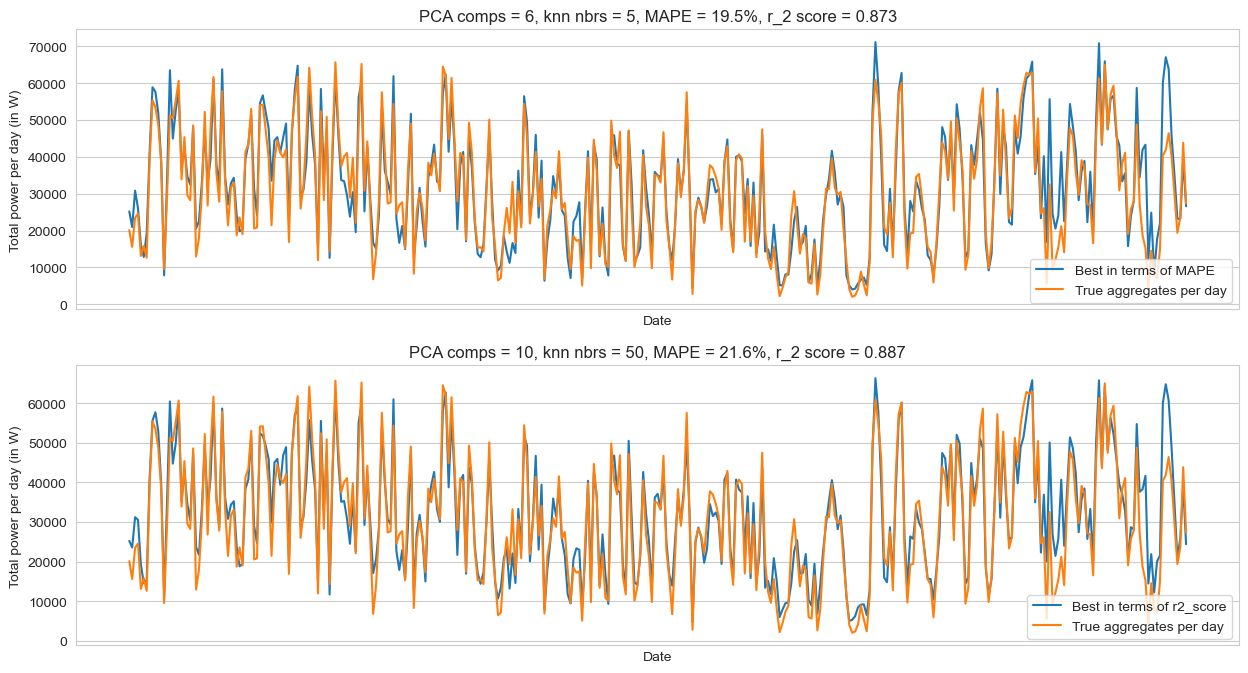

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(15, 8))


ax[0].plot(days_list, preds[best_MAPE_idx], label = 'Best in terms of MAPE')
ax[0].set_title(f"PCA comps = {dic[best_MAPE_idx][0]}, knn nbrs = {dic[best_MAPE_idx][1]}, MAPE = {mapes[best_MAPE_idx]*100:.1f}%, r_2 score = {r2s[best_MAPE_idx]:.3f}")

ax[1].plot(days_list, preds[best_r2_idx], label = 'Best in terms of r2_score')
ax[1].set_title(f"PCA comps = {dic[best_r2_idx][0]}, knn nbrs = {dic[best_r2_idx][1]}, MAPE = {mapes[best_r2_idx]*100:.1f}%, r_2 score = {r2s[best_r2_idx]:.3f}")

for i in range(2):
    ax[i].plot(true_aggregates.keys(), true_aggregates.values(), label = 'True aggregates per day')
    ax[i].legend(loc='lower right')
    ax[i].tick_params(axis='x', rotation = 45)
    ax[i].set_xticks([])
    ax[i].set_xlabel('Date')
    ax[i].set_ylabel('Total power per day (in W)')

plt.show()

In [ ]:
# fig, ax = plt.subplots(len(pca_comps)*len(n_nbrs), 1, figsize=(15, len(pca_comps)*len(n_nbrs)*3.5))
# for i in range(len(pca_comps)*len(n_nbrs)):
#     ax[i].plot(true_aggregates.keys(), true_aggregates.values(), label = 'True aggregates')
#     ax[i].plot(days_list, preds[i], label = 'kNN predicted')
#     ax[i].set_title(f"PCA componets = {dic[i][0]}, knn nbrs = {dic[i][1]}, MAPE = {mapes[i]*100:.1f}%, r_2 score = {r2s[i]:.3f}, MAE = {maes[i]:.1f}")
#     ax[i].legend(loc='upper right')
#     ax[i].tick_params(axis='x', rotation = 45)
#     ax[i].set_xticks([])

# plt.show()
